In [1]:
plate_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1.csv"
plate_1_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1_repeat.csv"
plate_2_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_1.csv"
plate_2_2 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_2.csv"
plate_2_3 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_3.csv"
plate_2_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat.csv"
plate_2_repeat_96 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat _96.csv"
list_A = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA.csv"
list_A_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA_repeat.csv"
list_B = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB.csv"
list_B_repeat_end = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _end.csv"
list_B_repeat_96 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _96.csv"
list_C = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listC.csv"

HsHis6_PEX5C_vs_HsPEX5C = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\Hs-His6-PEX5C vs HsPEX5C.csv"
HsPEX5C_Y467C_vs_AtPEX5C_WT = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\HsPEX5C Y467C vs AtPEX5C WT.csv"
F606C_vs_AtPEX5C_WT_1_hour = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\F606C vs AtPEX5C WT 1 hour.csv"

plate_map_file = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate_map.csv"
Hs_His6_PEX5C_vs_HsPEX5C_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\Hs-His6-PEX5C vs HsPEX5C platemap.csv"
HsPEX5C_Y467C_vs_AtPEX5C_WT_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\HsPEX5C Y467C vs AtPEX5C WT platemap.csv"
F606C_vs_AtPEX5C_WT_1_hour_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\F606C vs AtPEX5C WT 1 hour platemap.csv"

In [394]:
import csv
import re
import string
import math
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from plate_mapping import plate_mapping as pm

# define custom errors
class DataError(Exception):
    pass

class PlateSizeError(Exception):
    pass

class DataTypeError(Exception):
    pass

# define well plate dimensions
plate_dim = {96:(8, 12), 384:(16, 24)}

# define header names
pm.header_names = {'Well ID': {'dtype':str, 'long':True, 'short_row': False, 'short_col':False},
                'Type': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Contents': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Concentration Units':{'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                }

class FA:
    """Class used for the analysis of fluorescence anisotropy data.
    
    :param data_dict: A dictionary contaning data frames with pre-processed data and metadata
    :type data_dict: dict
    :param g_factor: G-factor
    :type g_factor: float 
    :param plate_map: dataframe from a plate map csv file that defines each and every well
    :type plate_map: pandas dataframe
    """
    def __init__(self, data_dict, g_factor, plate_map):
        self.data_dict = data_dict
        self.g_factor = g_factor
        self.plate_map = plate_map
        
        frames = []   # create list of all p and s data frames

        for repeat in self.data_dict.values():   
            metadata, data = repeat.values()
            p_channel, s_channel = data.values()
            frames.append(p_channel)
            frames.append(s_channel)
    
        new = pd.concat(frames, axis=1)   # join all p and s data frames into one df to run some stats
        nan = new.size - new.describe().loc['count'].sum()   # find number of 'nan' cells
        
        print("Data has been uploaded!\n")
        print(f"Value of g-factor: {self.g_factor} \nNumber of repeats: {len(self.data_dict)} \nOverall number of empty cells is {int(nan)} in {len(frames)} data frames.")
              
              
    @classmethod
    def read_in_envision(cls, data_csv, platemap_csv, data_type='plate', size=384):
        """Returns a dictionary of data frames, g-factor and platemap needed to construct the class object. 
        
        :param data_csv: File path of the raw data file in .csv format
        :type data_csv: str
        :param platemap_csv: File path of the platemap file in .csv format
        :type platemap_csv: str
        :param data_type: Format in which the raw data was exported (plate or list), defaults to plate
        :type data_type: str
        :param size: Size of the well plate (384 or 96), defaults to 384
        :type size: int
        :return: A dictionary contaning data frames with pre-processed data, g-factor, pandas data frame containing platemap
        :rtype: dict, float, pandas data frame """
        
        # ensure the plate size is either 384 or 96
        if size not in plate_dim:
            raise PlateSizeError('Invalid size of the well plate, should be 384 or 96.')
        
        # try to read in data in plate format
        if data_type == 'plate':
            try:
                data_dict, g_factor = FA._read_in_plate(data_csv, size=size)
                plate_map_df = pm.plate_map(platemap_csv, size=size)
                return cls(data_dict, g_factor, plate_map_df)
            
            except (UnboundLocalError, IndexError, ValueError):
                raise DataError(f"Error occured during data read in. Check your file contains data in the 'plate' format and plate size is {size}.")
        
        # try to read in data in list format
        if data_type == 'list':
            try:
                data_dict, g_factor = FA._read_in_list(data_csv, size=size)
                plate_map_df = pm.plate_map(platemap_csv, size=size)
                return cls(data_dict, g_factor, plate_map_df)
            
            except (UnboundLocalError, IndexError):
                raise DataError("Error occured during data read in. Check your file contains data in the 'list' format.")
        
        else:
            raise DataTypeError(f"'{data_type}' is not one of the two valid data types: plate or list.")
    

                
    def _read_in_plate(csv_file, size):
        """Reads the raw data file and finds the information needed to extract data. Passes those parameters to pre_process_plate function and executes it.
        Returns a tuple of two elemnts: dictionary of data frames and g-factor.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A tuple of dictionary of data frames and the g-factor 
        :rtype: tuple """
        
        with open(csv_file) as file:
            all_data_lines = list(csv.reader(file, delimiter=','))   # read the csv file and cast it into a list containing all lines

        blank_indexes = list(index for index, item in enumerate(all_data_lines) if item == [])   # list containing indices of all blank rows
        if blank_indexes == []:
            blank_indexes = list(index for index, item in enumerate(all_data_lines) if set(item) == {''})
        blanks = np.array(blank_indexes)   # convert the list of blank indices to a numpy array
        read_in_info = []   # list to store the tuples with parameters needed for pandas to read in the csv file

        for index, item in enumerate(all_data_lines):   # iterate over all lines in the csv file
            if item != [] and re.findall(r"Plate information", item[0]) == ['Plate information'] and re.search(r'Results for', all_data_lines[index + 9][0]) == None and re.findall(r"Formula", all_data_lines[index+1][10]) != ['Formula']:
                skiprows = index + 9   # Set the skiprows parameter for raw data table
                skiprows_meta = index + 1   # Set the skiprows parameter for metadata table
                end_of_data = blanks[blanks > skiprows].min()   # Calculate the end of data table by finding the smallest blank index after the beginning of data table
                read_in_info.append((skiprows, end_of_data - skiprows + 1, skiprows_meta))   # add the skiprows, caculated number of data lines and skiprows for metadata parameters to the list as a tuple
                data_format = 'plate1'

            if item != [] and re.findall(r"Plate information", item[0]) == ['Plate information'] and re.search(r'Results for', all_data_lines[index + 9][0]) != None:
                skiprows = index + 10
                skiprows_meta = index + 1
                end_of_data = blanks[blanks > skiprows].min()
                read_in_info.append((skiprows, end_of_data - skiprows - 1, skiprows_meta))
                data_format = 'plate2'

            if item != [] and len(item) > 1 and re.fullmatch(r"G-factor", item[0]):
                g_factor = float(item[4])   
        
        return FA._pre_process_plate(csv_file, read_in_info, data_format, size), g_factor

    
    def _pre_process_plate(csv_file, read_in_info, data_format, size):    
        """Extracts the data and metadata from the csv file, processes it and returns a nested dictionary containing data and metadata for each repeat and channel.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param read_in_info: Tuples with read in parameters for each channel.
        :type read_in_info: list
        :param data_format: Plate type (plate1 or plate2)
        :type data_format: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A dictionary containing data and metadata 
        :rtype: dict """ 
        
        data_frames = {}   # dictionary to store data frames
        counter = 1   # counter incremented by 0.5 to enable alternating labelling of data frames as 'p' or 's'

        row_letters = list(string.ascii_uppercase)[0: plate_dim[size][0]]   # generate a list of letters for well IDs
        col_numbers = list(np.arange(1, plate_dim[size][1] + 1).astype(str))   # generate a list of numbers for well IDs
        well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]   # generate a list of well IDs for the pre-processed data frames
        
        for index, item in enumerate(read_in_info):   # iterate over all tuples in the list, each tuple contains skiprows, nrows and skiprows_meta for one channel 

            if data_format == 'plate1':   # raw data table does not have row and column names so 'names' parameter passed to omit the last column
                raw_data = pd.read_csv(csv_file, sep=',', names=col_numbers, index_col=False, engine='python', skiprows=item[0], nrows=item[1], encoding='utf-8')

            if data_format == 'plate2':   # raw data table has row and column names, so index_col=0 to set the first column as row labels
                raw_data = pd.read_csv(csv_file, sep=',', index_col=0, engine='python', skiprows=item[0], nrows=item[1], encoding='utf-8')
                if len(raw_data.columns) in [13, 25]:    
                    raw_data.drop(raw_data.columns[-1], axis=1, inplace=True)    # delete the last column because it is empty

            # generate df for metadata (number of rows of metadata table is always 1) and convert measurement time into datetime object   
            metadata = pd.read_csv(csv_file, sep=',', engine='python', skiprows=item[2], nrows=1, encoding='utf-8').astype({'Measurement date': 'datetime64[ns]'})
            # convert and reshape data frame into 1D array
            data_as_array = np.reshape(raw_data.to_numpy(), (int(size), 1)) 

            if counter % 1 == 0: 
                new_data = pd.DataFrame(data=data_as_array, index=well_ids, columns=['p'])   # generate new 384 (or 96) by 1 data frame with p channel data
                data_frames[f'repeat_{int(counter)}'] = {'metadata':metadata, 'data': {'p': new_data, 's':''}}   # add p channel data and metadata dfs to dictionary

            if counter % 1 != 0:
                new_data = pd.DataFrame(data=data_as_array, index=well_ids, columns=['s'])   # generate new 384 (or 96) by 1 data frame with s channel data
                data_frames[f'repeat_{int(counter-0.5)}']['data']['s'] = new_data   # add s channel data to dictionary

            counter = counter + 0.5
        
        return data_frames


    def _read_in_list(csv_file, size):
        """Reads the raw data file and extracts the data and metadata. Passes the raw data to pre_process_list function and executes it.
        Returns a tuple of two elemnts: dictionary of data frames and g-factor.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A tuple of dictionary of data frames and the g-factor
        :rtype: tuple """

        with open(csv_file) as file:  
            all_data_lines = list(csv.reader(file, delimiter=',')) # read the csv file and cast it into a list containing all lines
 
        blank_indexes = list(index for index, item in enumerate(all_data_lines) if item == [] or set(item) == {''})   # list containing indexes of all blank rows
        blanks = np.array(blank_indexes)   # convert the list of blank indexes to a numpy array
        
        # iterate over all lines to find beggining of the data table ('skiprows') and determine the format of data  (list A, B, or C)
        for index, item in enumerate(all_data_lines):   
            if item != [] and len(item) == 1 and re.findall(r"Plate information", item[0]) == ["Plate information"]:
                skiprows_meta = index + 1
                end_of_metadata = blanks[blanks > skiprows_meta].min()   # find the end of metadata by finding the smallest blank index after the beginning of metadata
                
            if item != [] and len(item) >= 2 and re.findall(r"PlateNumber", item[0]) == ['PlateNumber'] and re.findall(r"PlateRepeat", item[1]) == ['PlateRepeat']:   # find line number with the beggining of the data
                skiprows = index - 1
                data_format = 'listA'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and len(item) >= 2 and re.findall(r"Plate", item[0]) == ['Plate'] and re.findall(r"Barcode", item[1]) == ['Barcode']:   # find line number with the beggining of the data
                skiprows = index
                data_format = 'listB'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and len(item) >= 2 and re.findall(r"Plate", item[0]) == ['Plate']  and re.findall(r"Well", item[1]) == ['Well']:
                skiprows = index
                data_format = 'listC'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and re.fullmatch(r"G-factor", item[0]):   # find the g factor
                g_factor = float(item[4])

        nrows = end_of_data - skiprows - 1   # calculate the length of data table
        nrows_meta = end_of_metadata - skiprows_meta - 1   # calucalte the length of metadata table (number of rows depends on the number of repeats)

        raw_data = pd.read_csv(csv_file, sep=',', engine='python', skiprows=skiprows, nrows=nrows, encoding='utf-8')
        raw_metadata = pd.read_csv(csv_file, sep=',', engine='python', skiprows=skiprows_meta, nrows=nrows_meta, encoding='utf-8')

        return FA._pre_process_list(raw_data, raw_metadata, data_format, size), g_factor


    def _pre_process_list(raw_data, raw_metadata, data_format, size):
        """Extracts the data and metadata for each channel and repeat from the raw data and raw metadata 
        and returns a nested dictionary containing data and metadata for each repeat and channel.

        :param raw_data: Data frame containing raw data
        :type raw_data: pandas data frame
        :param raw_metadata: Data frame containing raw metadata
        :type raw_metadata: pandas data frame
        :param data_format: Type of list (listA, listB, or listC)
        :type data_format: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A dictionary containing data and metadata
        :rtype: dict"""

        # remove the '0' from middle position of well numbers (A01 -> A1), done by reassigning the 'Well' column to a Series containing modified well numbers
        raw_data['Well'] = raw_data['Well'].apply(lambda x: x[0] + x[2] if x[1] == '0' else x)
        
        data_frames = {}   # dictionary to store data frames
        repeats = list(raw_metadata['Repeat'].to_numpy())   # generate a list with repeats based on the metadata table, e.g. for 3 repeats -> [1,2,3]

        row_letters = list(string.ascii_uppercase)[0: plate_dim[size][0]]   # generate a list of letters for well IDs
        col_numbers = list(np.arange(1, plate_dim[size][1] + 1).astype(str))   # generate a list of numbers for well IDs
        well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]   # generate a list of well IDs for the pre-processed data frames
        
        for index, repeat in enumerate(repeats):   # iterate over the number of repeats
            if data_format == 'listA':
                groupped_data = raw_data.groupby(raw_data.PlateRepeat).get_group(repeat)   # group and extract the data by the plate repeat column, i.e. in each iteration get data only for the current repeat 

                p_groupped = groupped_data.iloc[::3, :]   # extract data only for the p channel, i.e. each third row starting from the first row
                s_groupped = groupped_data.iloc[1::3, :]   # extract data only for the s channel, i.e. each third row starting from the second row

                p_raw_data = p_groupped[['Well', 'Signal']]   # extract only the two relevant columns
                s_raw_data = s_groupped[['Well', 'Signal']]   # for each channel

            if data_format in ['listB', 'listC']: 
                # the column naming is different for the first repeat ('Signal'), then it's 'Signal.1', 'Signal.2', etc.
                if repeat == 1: 
                    p_raw_data = raw_data[['Well', 'Signal']]   
                    s_raw_data = raw_data[['Well', f'Signal.{repeat}']]
                else:
                    p_raw_data = raw_data[['Well', f'Signal.{repeat + index - 1}']]   # the column cotntaining data to be extracted is calculated in each iteration
                    s_raw_data = raw_data[['Well', f'Signal.{repeat + index}']]
            
            # create an empty df with no columns and indexes matching the plate size
            indexes = pd.DataFrame(well_ids, columns=['Wells'])
            empty_frame = indexes.set_index('Wells')
            
            p_raw_data.set_index('Well', inplace=True)   # set the row indexes as the well numbers
            p_raw_data.set_axis(['p'], axis=1, inplace=True)   # rename the 'Signal' column to 'p'
            p_data = empty_frame.join(p_raw_data)   # join the raw data df to an empty frame based on the indexes, assigns 'NaN' to indexes not present in the raw data table
            
            s_raw_data.set_index('Well', inplace=True) 
            s_raw_data.set_axis(['s'], axis=1, inplace=True)
            s_data = empty_frame.join(s_raw_data)
    
            metadata = raw_metadata.iloc[[repeat-1]].astype({'Measurement date': 'datetime64[ns]'})   # extract the row with metadata relevant for each repeat and covert date and time into a datetime object
            data_frames[f'repeat_{repeat}'] = {'metadata': metadata, 'data': {'p': p_data, 's': s_data}}   # add data frames to the dictionary

        return data_frames
    
    
    def visualise(self, colorby='Type', labelby='Type', title="", cmap='Paired', dpi=250, export=False):
        """Returns a visual representation of the plate map.
        The label and colour for each well can be customised to be a variable, for example 'Type', 'Protein Name', 'Protein Concentration', etc.
        It can also be the p or s anisotropy value from a specified repeat passed as a tuple of strings, for example ('repeat_2', 'p') for p data from repeat 2
        
        :param colorby: Chooses the parameter to color code by, for example 'Type', 'Contents', 'Protein Concentration', ('repeat_2', 'p'), default = 'Type'
        :type colorby: str or tuple
        :param labelby: Chooses the parameter to label code by, for example 'Type', 'Contents', 'Protein', ('repeat_1', 's'), default = 'Type'
        :type labelby: str or tuple
        :param title: Sets the title of the figure, default none
        :type title: str
        :param cmap: Sets the colormap for the color-coding, default = 'Paired'
        :type cmap: str
        :param dpi: Size of the figure, default = 250
        :type dpi: int
        :param export: If 'True' a .png file of the figure is saved, default = False
        :type export: bool
        :return: Visual representation of the plate map.
        :rtype: figure
        """
        plate_map = self.plate_map
        scinot = False
        
        if type(labelby) == tuple:   # option for labelling by the p or s anisotropy values
            plate_map = self.plate_map.join(self.data_dict[labelby[0]]['data'][labelby[1]])   # data frame containing p or s values from specified repeat is added to the platemap
            labelby = labelby[1]
        if type(colorby) == tuple:   # option for colouring by the p or s anisotropy values
            plate_map = self.plate_map.join(self.data_dict[colorby[0]]['data'][colorby[1]])
            colorby = colorby[1]
            
        size = plate_map.shape[0]
        
        if labelby in ['Protein Concentration', 'Tracer Concentration', 'Competitor Concentration', 'p', 's', 'p_corrected', 's_corrected', 'r_raw', 'r_corrected', 'i_raw' , 'i_corrected']:
            if sum((plate_map[labelby] > 1000) | (plate_map[labelby] < 0)) > 0:   # display in sci notation if the number is greater than 1000 or less than 0
                scinot = True
        
        return pm.visualise(platemap=plate_map, title=title, size=size, export=export, cmap=cmap, colorby=colorby, labelby=labelby, scinot=scinot, dpi=dpi)
    
    
    def invalidate(self, valid=False, **kwargs):
        """Invalidates wells, columns and/or rows. Any of the following arguments, or their combination, can be passed: wells, rows, columns. 
        For example to invalidate well A1, rows C and D and columns 7 and 8 execute the following: invalidate(wells='A1', rows=['C','D'], columns=[7,8]).
        To validate previously invalidated wells, rows and/or columns, pass the additional 'valid' argument as True.
    
        :param valid: Sets the stipulated row or rows 'True' or 'False', default = False
        :type valid: bool
        :param wells: Wells to be invalidated passed as a string or a list of strings
        :type wells: str or list
        :param rows: Rows to be invalidated passed as a string or a list of strings
        :type rows: str or list
        :param columns: Columns to be invalidated passed as an integer or a list of integers
        :type columns: int or list
        """
        # execute the corresponding invalidate functon from the platemapping package
        if 'wells' in kwargs:
            pm.invalidate_wells(platemap=self.plate_map, wells=kwargs['wells'], valid=valid)
        if 'rows' in kwargs:
            rows = tuple(kwargs['rows']) # convert the rows to tuple because invalidate_rows cannot take in a list
            pm.invalidate_rows(platemap=self.plate_map, rows=rows, valid=valid)
        if 'columns' in kwargs:
            pm.invalidate_cols(platemap=self.plate_map, cols=kwargs['columns'], valid=valid)
        if len(kwargs) == 0:   # return error if neither of the keyword arguments is passed
            raise TypeError('No arguments were passed. Specify the wells, rows or columns to be invalidated!')
            
            
    def background_correct(self):
        """Calculate background corrected values for p and s channel in all repeats.
        
        Cacluclated by subtracting the mean value of blank p or s for a given concentration from each value of compound p or s for that concentration."""
        
        for key, value in self.data_dict.items(): 
            metadata, data = value.values()   
            p, s = data.values()             
            
            # create joined dfs of platemap and p or s
            p_df = self.plate_map.join(p)  
            s_df = self.plate_map.join(s)
            
            # calculate p and s corrected and add them to data dictionary
            self.data_dict[key]['data']['p_corrected'] = FA._backg_correct(p_df, 'p_corrected')
            self.data_dict[key]['data']['s_corrected'] = FA._backg_correct(s_df, 's_corrected')
            
            print('Background correction has been successfully performed!')
            
    def _backg_correct(df, col_name):
        """Calculate background corrected p or s.
        
        :param df: Joined platemap and raw p or s values 
        :type df: pandas df
        :param col_name: Name of the column with background corrected values
        :type col_name: str
        :return: Data frame with background corrected p or s values (depending on col_name parameter)
        :rtype: pandas df"""
        
        df[df.columns[-1]] = df[df.columns[-1]][df['Valid'] == True]   # 'p' or 's' values are replaced with NaN if the well is invalidated
        no_index = df.reset_index()   # move the index to df column

        mindex = pd.MultiIndex.from_frame(no_index[['Type', 'Protein Name', 'Protein Concentration']])   # create multiindex
        reindexed = no_index.set_index(mindex).drop(['Type', 'Protein Name', 'Protein Concentration'], axis=1)   # add multiindex to df and drop the columns from which multiindex was created
        
        mean = reindexed.groupby(level=[0,1,2]).mean().drop('Valid', axis=1)   # calculate mean for each group of three wells and remove 'Valid' column
        mean.rename(columns={mean.columns[-1]: 'Mean'}, inplace=True)   # rename the last column to 'Mean'

        blank = mean.xs('blank', level=0, drop_level=True)   # take a group with blank wells
        
        joined = reindexed.join(blank, on=['Protein Name', 'Protein Concentration'])
        joined[col_name] = joined[joined.columns[-2]] - joined['Mean']   # calculate background corrected values
        jindexed = joined.set_index('index', append=True).reset_index(level=[0,1,2]).rename_axis(None)   # set index to 'well id' and move multiindex to df columns
        
        return jindexed[[col_name]]
    
    
    def calculate_r_i(self, corrected=True, th=80):
        """Calculates anisotropy and fluorescence intensity.
        The fluorescence intensity (I) and anisotropy (r) are calculated using the follwing formulas: I = s + (2*g*p), r = (s - (g*p)) / I and stored 
        in data_dict as i_raw and r_raw (calculated using the uncorrected p and s channel values) 
        and i_corrected and r_corrected (if calculated using the background corrected p and s channel values, as well).
        
        :param corrected: Calculate the anisotropy and intensity using the background corrected values of p and s, as well, default=True
        :type corrected: bool
        :param th:
        :type th: float"""
        
        for key, value in self.data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            
            # calculate raw intensity and anisotropy and add them to data dictionary
            i, r = FA._calc_r_I(data['p'], data['s'], self.g_factor, 'raw')
            self.data_dict[key]['data']['i_raw'] = i   
            self.data_dict[key]['data']['r_raw'] = r   
            
            if corrected:   # calculate intensity and anisotropy using background corrected values of p and s
                if 'p_corrected' and 's_corrected' not in data:   # check if background subtraction has been done
                    raise AttributeError('The corrected anisotropy and intensity can only be calculated after background correction of the raw p and s channel data.')
                
                i_c, r_c = FA._calc_r_I(data['p_corrected'], data['s_corrected'], self.g_factor, 'corrected')
                self.data_dict[key]['data']['i_corrected'] = i_c   
                self.data_dict[key]['data']['r_corrected'] = r_c    
                
        print('Fluorescence intensity and anisotropy have been calculated!\n')

        
    def _calc_r_I(p, s, g, col_suffix):
        """Calculates either anisotropy or intensity and labels the resulting dfs according to the parameters passed
        
        :param p: Pandas data frame with p channel data (can be both raw and background corrected)
        :type p: pandas df 
        :param s: Pandas data frame with s channel data (can be both raw and background corrected)
        :type s: pandas df
        :param g: G-factor
        :type g: float
        :param col_suffix: Suffix to add to column name of the resulting intensity or anisotropy data frame, e.g. 'raw', 'corrected'
        :type col_suffix: str
        :return: Data frames with calculated anisotropy and intensity values
        :rtype: pandas df"""
        
        p_rn = p.rename(columns={p.columns[0]: s.columns[0]})   # rename the col name in p data frame so that both p and s dfs have the same col names to enable calculation on dfs
        i = s + (2 * g * p_rn)       
        r = (s - (g * p_rn)) / i
        i_rn = i.rename(columns={i.columns[0]: 'i_'+col_suffix})   # rename the col name using the column suffix argument
        r_rn = r.rename(columns={r.columns[0]: 'r_'+col_suffix})           
            
        return i_rn, r_rn  
    
    
    def _calc_I_percent(rep, th, ir, ic, platemap):
        """Calculate the percentage intensity of blank wells compared to non-blank wells.
        
        :param rep: The current repeat number
        :type rep: str
        :param th: Threshold above which the wells are added to a list
        :type th: float
        :param ir: Data frame with corrected intensity 
        :type ir: pandas df
        :param ic: Data frame with raw intensity
        :type ic: pandas df
        :param platemap: Platemap
        :type platemap: pandas df
        :return: A tuple with information about the repeat number, list of wells above the threshold and df containing only the non-blank and non-empty columns
        :rtype: str, list, pandas df"""
        
        ir_rn = ir.rename(columns={ir.columns[0]:ic.columns[0]})   # rename the col name in raw intensity df so that it's the same as in corrected intensity df
        percent = (ir_rn - ic)/ir_rn * 100   
        percent.rename(columns={'i_corrected':'percent'}, inplace=True)
        joined = platemap.join(ratio)   # join the percent data to platemap
        subset = joined[(joined['Type'] != 'blank') & (joined['Type'] != 'empty')]   # subset only the non-blank and non-empty columns
        wells = list(subset[subset['percent'] > th].index)   # get a list of wells with percentage value above the threshold
        
        return rep, wells, subset

In [395]:
my_data1 = FA.read_in_envision(data_csv=HsHis6_PEX5C_vs_HsPEX5C, platemap_csv=Hs_His6_PEX5C_vs_HsPEX5C_platemap, data_type='plate', size=384)

Data has been uploaded!

Value of g-factor: 1.0 
Number of repeats: 1 
Overall number of empty cells is 192 in 2 data frames.


In [396]:
my_data1.background_correct()

Background correction has been successfully performed!


In [397]:
my_data1.calculate_r_i()

Fluorescence intensity and anisotropy have been calculated!

[('repeat_1', [],          Type Contents   Protein Name Protein Concentration      Tracer Name  \
A1   compound      NaN  Hs-His6-PEX5C                 10000  Lissamine-YQSKL   
A2   compound      NaN  Hs-His6-PEX5C               6666.67  Lissamine-YQSKL   
A3   compound      NaN  Hs-His6-PEX5C               4444.44  Lissamine-YQSKL   
A4   compound      NaN  Hs-His6-PEX5C               2962.96  Lissamine-YQSKL   
A5   compound      NaN  Hs-His6-PEX5C               1975.31  Lissamine-YQSKL   
..        ...      ...            ...                   ...              ...   
I20  compound      NaN        HsPEX5C                  4.51  Lissamine-YQSKL   
I21  compound      NaN        HsPEX5C                  3.01  Lissamine-YQSKL   
I22  compound      NaN        HsPEX5C                     2  Lissamine-YQSKL   
I23  compound      NaN        HsPEX5C                  1.34  Lissamine-YQSKL   
I24  compound      NaN        HsPEX5C    

In [380]:
my_data1.data_dict['repeat_1']['data']['i_corrected']

,i_corrected
index,
A1,393886.666667
A2,259605.000000
A3,411921.666667
A4,404444.333333
A5,443401.000000
...,...
P20,NaN
P21,NaN
P22,NaN


In [381]:
my_data1.data_dict['repeat_1']['data']['i_raw']

,i_raw
A1,531652.0
A2,403058.0
A3,581404.0
A4,542383.0
A5,575659.0
...,...
P20,NaN
P21,NaN
P22,NaN
P23,NaN


In [ ]:
d.append(FA._calc_I_percent(key, th, i, i_c, self.plate_map))

In [77]:
add = my_data1.data_dict['repeat_1']
custom = my_data1.data_dict
custom['repeat_2'] = add

In [78]:
raw = custom['repeat_1']['data']['i_raw']
corr = custom['repeat_1']['data']['i_corrected']

In [79]:
r = (raw['i_raw']-corr['i_corrected'])/raw['i_raw']
ratio = r.to_frame()
ratio.rename(columns={0:'ratio'}, inplace=True)

In [80]:
j = my_data1.plate_map.join(ratio2)

In [81]:
sub = j[(j['Type'] != 'blank') & (j['Type'] != 'empty')]

In [82]:
th = 0.6

In [200]:
def calc_I(rep,th, ir, ic):
    ir_rn = ir.rename(columns={ir.columns[0]:ic.columns[0]})
    ratio = (ir_rn - ic)/ir_rn
    ratio.rename(columns={'i_corrected':'percent'}, inplace=True)
    j = my_data1.plate_map.join(ratio)
    subset = j[(j['Type'] != 'blank') & (j['Type'] != 'empty')]
    wells = list(subset[subset['percent'] > th].index)
    return rep, wells, subset

In [201]:
l = []
for key, value in custom.items():   # iterate over all repeats
    metadata, data = value.values()

    q = calc_I(key, 0.4, data['i_raw'], data['i_corrected'])
    l.append(q)

In [280]:
l2 = [l[0]]

In [282]:
fig = plt.figure(figsize=(13,6))
fig.suptitle('Title', fontsize=14)

for index, item in enumerate(l2):
    if len(l2) != 1:
        ax = plt.subplot(ceil((index+1)/2),2, index+1)
    else:
        ax = plt.figure()
    ax.bar(item[2].index, item[2]['percent'], color='royalblue')
    ax.axhline(0.8, color='red')
    ax.set_title(item[0])
    ax.set_xlabel('well ids')
    ax.set_ylabel('percent')

AttributeError: 'Figure' object has no attribute 'bar'

<Figure size 936x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

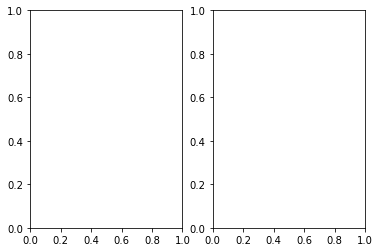

In [285]:
nr = 1
nc = 2
fig, axs = plt.subplots(nr, nc)

for row in range(nr):
    for col in range(nc):
        ax = axs[row, col]
        ax.bar(l[0][2].index, l[0][2]['percent'], color='royalblue')

<BarContainer object of 144 artists>

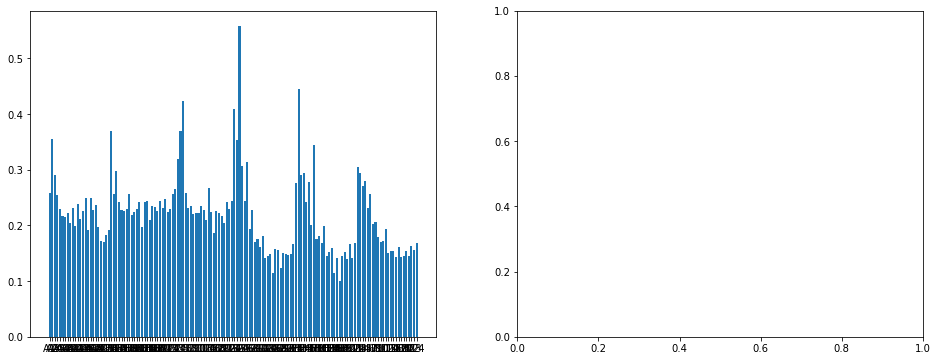

In [211]:
fig, axs = plt.subplots(ceil(len(l)/2), 2, figsize=(16,6))
#for index, item in enumerate(l):    
#plt.subplot(1,1,1)
axs[0].bar(l[0][2].index, l[0][2]['percent'])
#plt.subplot(1,1,2)
#plt.bar(l[1][2].index, l[1][2]['percent'])

<BarContainer object of 144 artists>

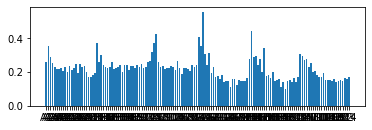

In [218]:
plt.subplot(2,1,1)
plt.bar(l[0][2].index, l[0][2]['percent'])

No cells above threshold.


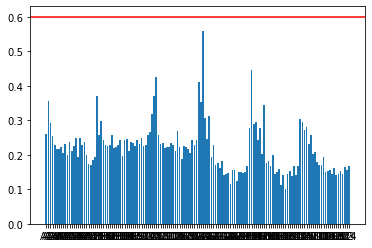

In [87]:
plt.bar(sub.index, sub['ratio'])
plt.axhline(th, color='red')
wells = list(sub[(sub['Type'] != 'blank') & (sub['ratio'] > th)].index)
if wells != []:
    print(f'In the following wells the values are greater than {int(th*100)}% threshold:')
    print(f'\trepeat_1: {wells}')
else:
    print('No cells above threshold.')

<BarContainer object of 144 artists>

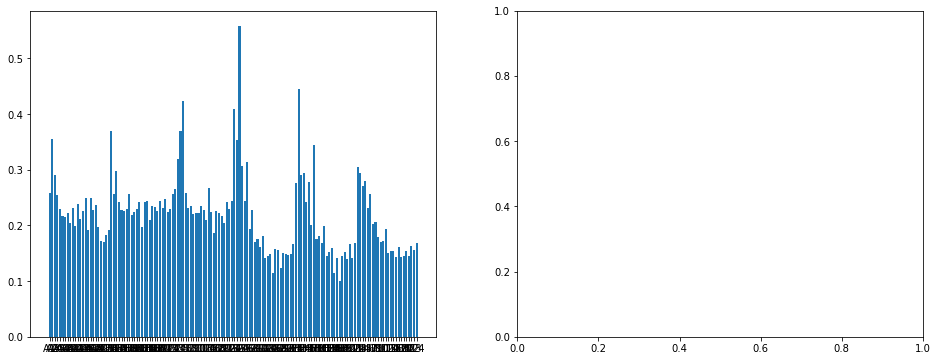

In [122]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
axs[0].bar(sub.index, sub['ratio'])

In [14]:
my_data2 = FA.read_in_envision(data_csv=HsPEX5C_Y467C_vs_AtPEX5C_WT, platemap_csv=HsPEX5C_Y467C_vs_AtPEX5C_WT_platemap, data_type='plate', size=384)
my_data2.background_correct()
my_data2.calculate_r_i()

Data has been uploaded!

Value of g-factor: 1.0 
Number of repeats: 1 
Overall number of empty cells is 192 in 2 data frames.
Background correction has been successfully performed!
Fluorescence intensity and anisotropy have been calculated!


In [15]:
my_data3 = FA.read_in_envision(data_csv=F606C_vs_AtPEX5C_WT_1_hour, platemap_csv=F606C_vs_AtPEX5C_WT_1_hour_platemap, data_type='plate', size=384)
my_data3.background_correct()
my_data3.calculate_r_i()

Data has been uploaded!

Value of g-factor: 1.0 
Number of repeats: 1 
Overall number of empty cells is 192 in 2 data frames.
Background correction has been successfully performed!
Fluorescence intensity and anisotropy have been calculated!


In [31]:
with open('C:\\Users\\Bartek\\Desktop\\cor.csv') as file:
    d = pd.read_csv(file, index_col=0)

row_letters = list(string.ascii_uppercase)[0: 16]   # generate a list of letters for well IDs
col_numbers = list(np.arange(1, 25).astype(str))   # generate a list of numbers for well IDs
well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]   # generate a list of well IDs for the pre-processed data frames
data_as_array = np.reshape(d.to_numpy(), (384, 1)) 
new_data = pd.DataFrame(data=data_as_array, index=well_ids, columns=['p_corrected'])
new_data.rename_axis('index', inplace=True)

In [32]:
pd.testing.assert_frame_equal(out, new_data)

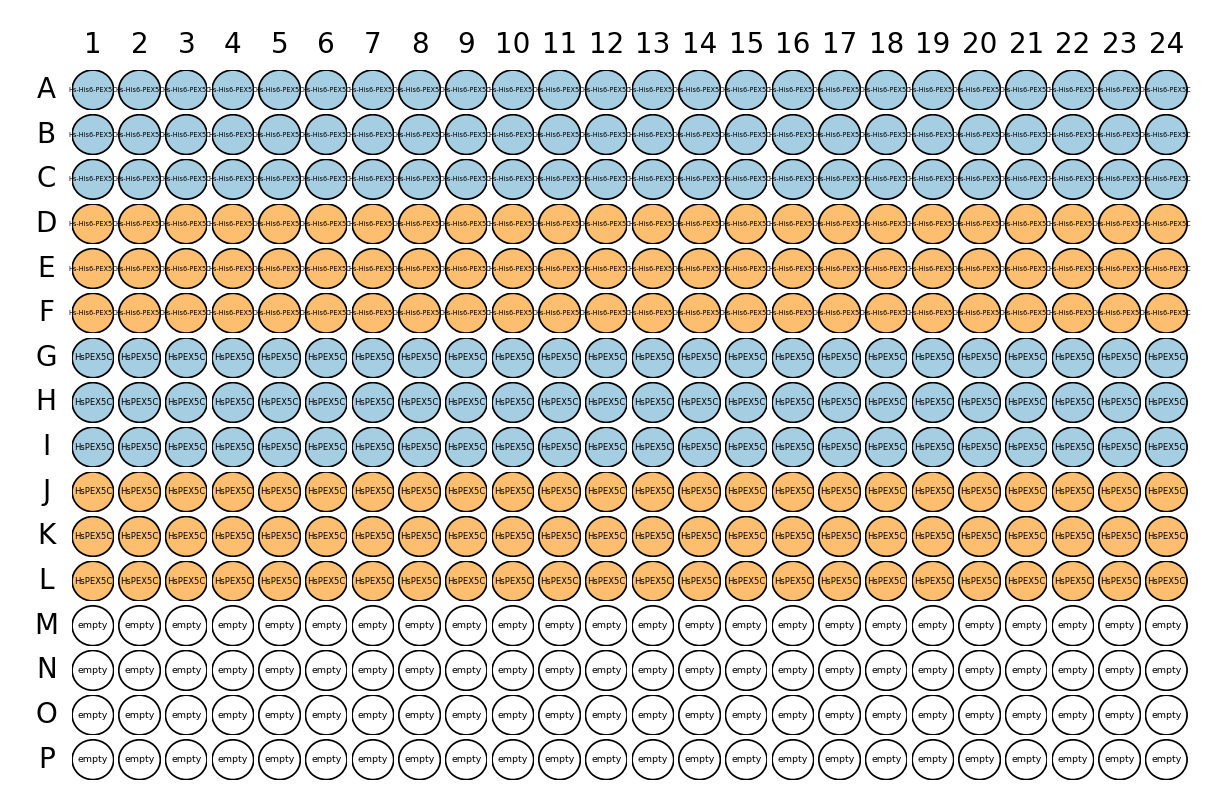

In [21]:
my_data1.visualise(labelby='Protein Name', colorby='Type')

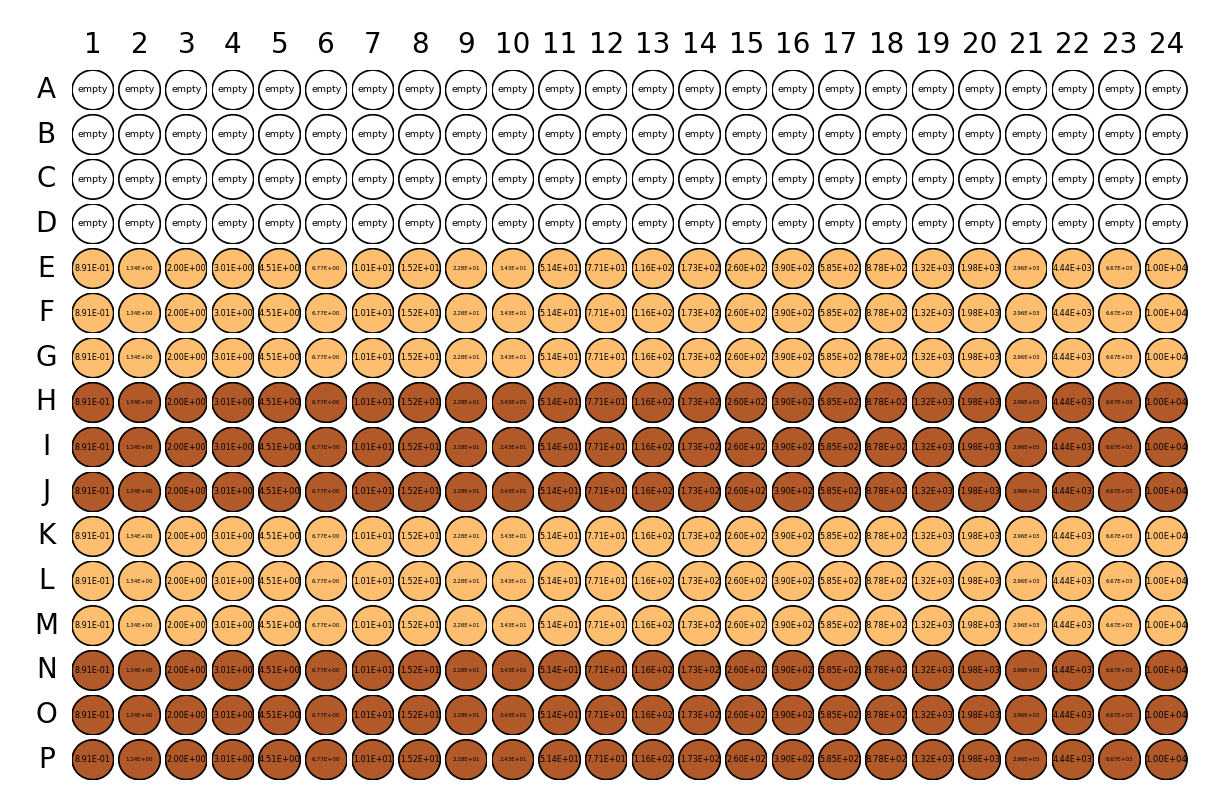

In [9]:
my_data3.visualise(labelby='Protein Concentration', colorby='Type')

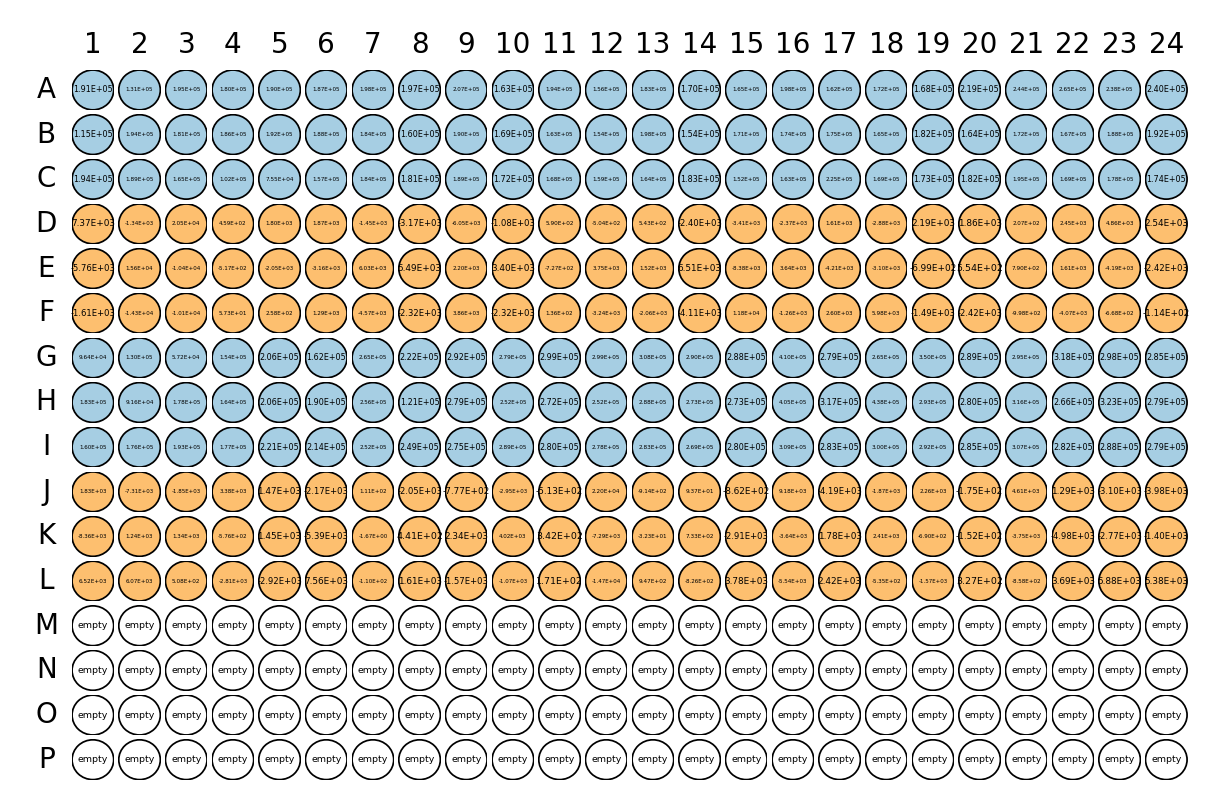

In [59]:
my_data1.visualise(labelby=('repeat_1', 's_corrected'), colorby='Type')

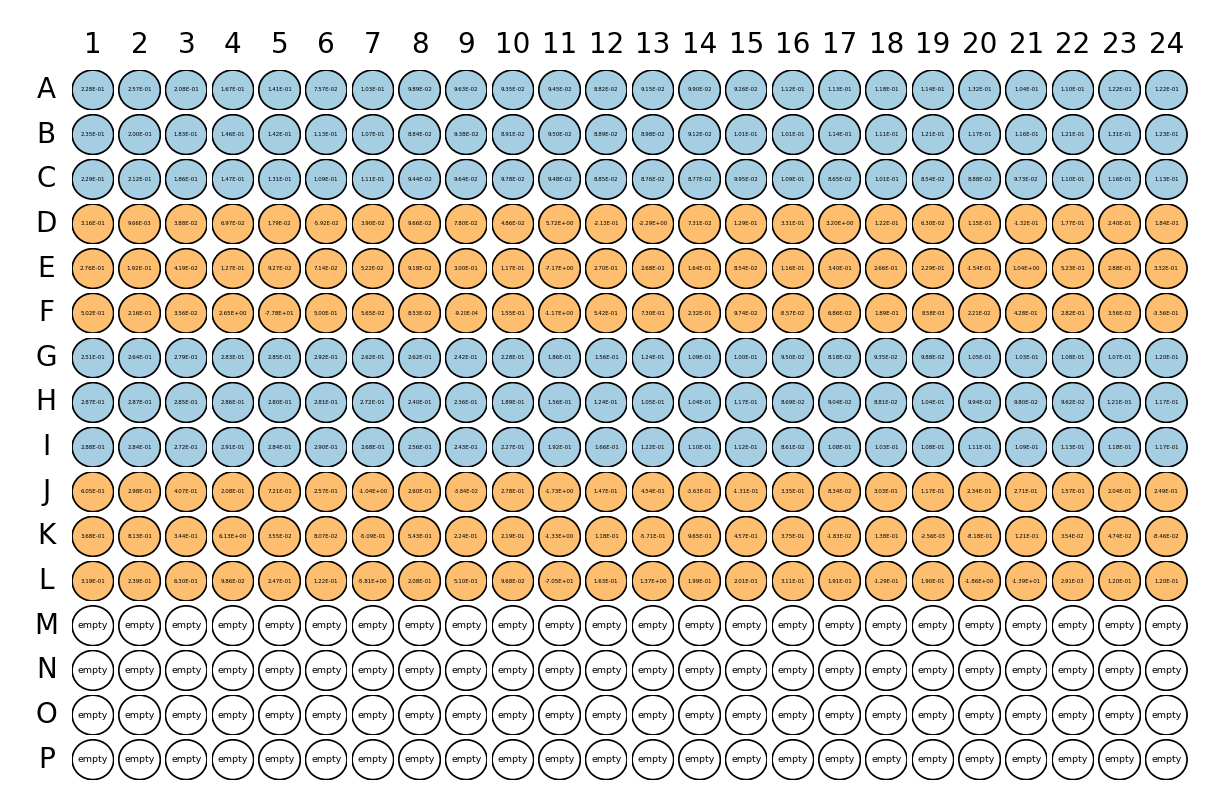

In [60]:
my_data1.visualise(labelby=('repeat_1', 'r_corrected'), colorby='Type')

In [62]:
my_data1.data_dict['repeat_1']['data']

{'p':             p
 A1   137450.0
 A2   102467.0
 A3   155187.0
 A4   148702.0
 A5   161974.0
 ..        ...
 P20       NaN
 P21       NaN
 P22       NaN
 P23       NaN
 P24       NaN
 
 [384 rows x 1 columns],
 's':             s
 A1   256752.0
 A2   198124.0
 A3   271030.0
 A4   244979.0
 A5   251711.0
 ..        ...
 P20       NaN
 P21       NaN
 P22       NaN
 P23       NaN
 P24       NaN
 
 [384 rows x 1 columns],
 'p_corrected':          p_corrected
 index               
 A1     101370.333333
 A2      64287.333333
 A3     108688.000000
 A4     112349.000000
 A5     126901.666667
 ...              ...
 P20              NaN
 P21              NaN
 P22              NaN
 P23              NaN
 P24              NaN
 
 [384 rows x 1 columns],
 's_corrected':          s_corrected
 index               
 A1     191146.000000
 A2     131030.333333
 A3     194545.666667
 A4     179746.333333
 A5     189597.666667
 ...              ...
 P20              NaN
 P21              NaN
 P22         

In [76]:
r = my_data1.data_dict['repeat_1']['data']['r_corrected']
p = my_data1.plate_map['Protein Concentration']

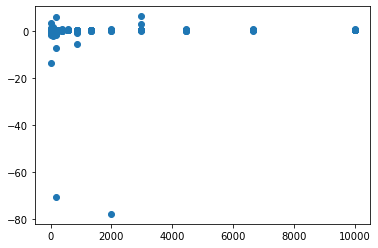

In [77]:
plt.scatter(p, r)